In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/d/bryanmariscal/trigger-word-training/Y.npy
/kaggle/input/d/bryanmariscal/trigger-word-training/X.npy
/kaggle/input/d/bryanmariscal/trigger-word-training/synthesized/train615.wav
/kaggle/input/d/bryanmariscal/trigger-word-training/synthesized/train394.wav
/kaggle/input/d/bryanmariscal/trigger-word-training/synthesized/train465.wav
/kaggle/input/d/bryanmariscal/trigger-word-training/synthesized/train80.wav
/kaggle/input/d/bryanmariscal/trigger-word-training/synthesized/train484.wav
/kaggle/input/d/bryanmariscal/trigger-word-training/synthesized/train631.wav
/kaggle/input/d/bryanmariscal/trigger-word-training/synthesized/train159.wav
/kaggle/input/d/bryanmariscal/trigger-word-training/synthesized/train555.wav
/kaggle/input/d/bryanmariscal/trigger-word-training/synthesized/train964.wav
/kaggle/input/d/bryanmariscal/trigger-word-training/synthesized/train16.wav
/kaggle/input/d/bryanmariscal/trigger-word-training/synthesized/train210.wav
/kaggle/input/d/bryanmariscal/trigger-w

In [4]:
import numpy as np
from pydub import AudioSegment
import random
import sys
import io
import os
import glob
import IPython
import scipy.signal as sig
from scipy.io.wavfile import read
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import AutoMinorLocator,LogLocator
get_ipython().magic('matplotlib inline')

In [5]:
X = np.load('/kaggle/input/d/bryanmariscal/trigger-word-training/X.npy')
Y = np.load('/kaggle/input/d/bryanmariscal/trigger-word-training/Y.npy')
Y = Y.swapaxes(1,2)

In [6]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, Callback, EarlyStopping
from keras.models import Model, load_model, Sequential
from keras.layers import Dense, Activation, Dropout, Input, Masking, TimeDistributed, LSTM, Conv1D
from keras.layers import GRU, Bidirectional, BatchNormalization, Reshape
from keras.optimizers import Adam, SGD

In [7]:
def model(input_shape):
    """
    Function creating the model's graph in Keras.
    
    Argument:
    input_shape -- shape of the model's input data (using Keras conventions)

    Returns:
    model -- Keras model instance
    """
    
    X_input = Input(shape = input_shape)
    
    ### START CODE HERE ###
    
    # Step 1: CONV layer (≈4 lines)
    X = Conv1D(filters=196,kernel_size=15,strides=4)(X_input)                                 # CONV1D
    X = BatchNormalization()(X)                                # Batch normalization
    X = Activation("relu")(X)                                 # ReLu activation
    X = Dropout(rate=0.8)(X)                                # dropout (use 0.8)

    # Step 2: First GRU Layer (≈4 lines)
    X = GRU(units=128, return_sequences = True)(X)         # GRU (use 128 units and return the sequences)
    X = Dropout(rate=0.8)(X)                                 # dropout (use 0.8)
    X = BatchNormalization()(X)                # Batch normalization
    
    # Step 3: Second GRU Layer (≈4 lines)
    X = GRU(units=128, return_sequences = True)(X)                                 # GRU (use 128 units and return the sequences)
    X = Dropout(rate=0.8)(X)                                 # dropout (use 0.8)
    X = BatchNormalization()(X)                                 # Batch normalization
    X = Dropout(rate=0.8)(X)                                # dropout (use 0.8)
        
    # Step 4: Time-distributed dense layer (see given code in instructions) (≈1 line)
    X = TimeDistributed(Dense(1, activation = "sigmoid"))(X) # time distributed  (sigmoid)

    ### END CODE HERE ###

    model = Model(inputs = X_input, outputs = X)
    
    return model  


In [8]:
model = model(input_shape = (860, 129)) #Tx, nfreq


In [9]:
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 860, 129)]        0         
_________________________________________________________________
conv1d (Conv1D)              (None, 212, 196)          379456    
_________________________________________________________________
batch_normalization (BatchNo (None, 212, 196)          784       
_________________________________________________________________
activation (Activation)      (None, 212, 196)          0         
_________________________________________________________________
dropout (Dropout)            (None, 212, 196)          0         
_________________________________________________________________
gru (GRU)                    (None, 212, 128)          125184    
_________________________________________________________________
dropout_1 (Dropout)          (None, 212, 128)          0     

In [10]:
from keras import backend as K
import keras 
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))
def scheduler(epoch, learning_rate):
    #Can define custom function for learning_rate
    return learning_rate

class CustomLearningRateScheduler(Callback):
    """Learning rate scheduler which sets the learning rate according to schedule.

  Arguments:
      schedule: a function that takes an epoch index
          (integer, indexed from 0) and current learning rate
          as inputs and returns a new learning rate as output (float).
  """

    def __init__(self, schedule):
        super(CustomLearningRateScheduler, self).__init__()
        self.schedule = schedule

    def on_epoch_begin(self, epoch, logs=None):
        if not hasattr(self.model.optimizer, "learning_rate"):
            raise ValueError('Optimizer must have a "learning_rate" attribute.')
        # Get the current learning rate from model's optimizer.
        lr = float(keras.backend.get_value(self.model.optimizer.learning_rate))
        # Call schedule function to get the scheduled learning rate.
        scheduled_lr = self.schedule(epoch, lr)
        # Set the value back to the optimizer before this epoch starts
        keras.backend.set_value(self.model.optimizer.learning_rate, scheduled_lr)
        print("\nEpoch %05d: Learning rate is %6.4f." % (epoch+1, scheduled_lr))
        
callback = CustomLearningRateScheduler(scheduler)

In [11]:
opt = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, decay=0.01)
model.compile(loss='binary_crossentropy', optimizer=opt,metrics=['accuracy',f1_m,recall_m,precision_m])

In [12]:
history = model.fit(X,Y,validation_split=0.3,batch_size = 64, epochs=100,verbose=2,callbacks=[callback])

Epoch 1/100

Epoch 00001: Learning rate is 0.0100.
11/11 - 11s - loss: 0.9181 - accuracy: 0.6061 - f1_m: 0.2826 - recall_m: 0.4545 - precision_m: 0.2073 - val_loss: 0.5180 - val_accuracy: 0.7820 - val_f1_m: 0.5103 - val_recall_m: 0.7274 - val_precision_m: 0.3936
Epoch 2/100

Epoch 00002: Learning rate is 0.0100.
11/11 - 1s - loss: 0.5083 - accuracy: 0.7844 - f1_m: 0.4861 - recall_m: 0.6124 - precision_m: 0.4054 - val_loss: 0.4250 - val_accuracy: 0.8003 - val_f1_m: 0.5809 - val_recall_m: 0.8852 - val_precision_m: 0.4327
Epoch 3/100

Epoch 00003: Learning rate is 0.0100.
11/11 - 1s - loss: 0.3802 - accuracy: 0.8629 - f1_m: 0.6162 - recall_m: 0.6577 - precision_m: 0.5864 - val_loss: 0.5316 - val_accuracy: 0.8627 - val_f1_m: 0.2329 - val_recall_m: 0.1334 - val_precision_m: 0.9427
Epoch 4/100

Epoch 00004: Learning rate is 0.0100.
11/11 - 1s - loss: 0.2728 - accuracy: 0.9018 - f1_m: 0.7052 - recall_m: 0.7080 - precision_m: 0.7063 - val_loss: 0.6655 - val_accuracy: 0.8685 - val_f1_m: 0.2834 

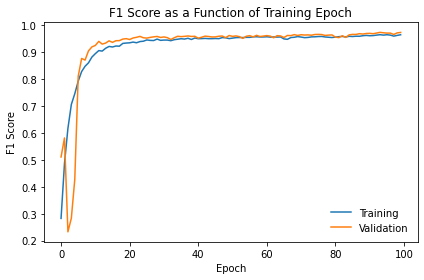

In [13]:
plt.plot(history.history['f1_m'],label='Training')
plt.plot(history.history['val_f1_m'],label='Validation')
plt.legend(frameon=False)
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('F1 Score as a Function of Training Epoch')
plt.tight_layout()
plt.savefig('f1score.png',dpi=400,facecolor='w')

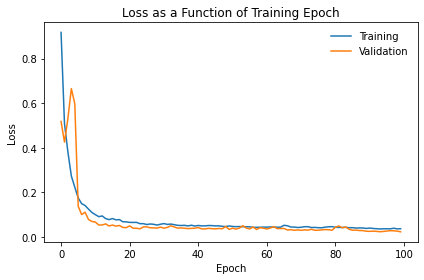

In [14]:
plt.plot(history.history['loss'],label='Training')
plt.plot(history.history['val_loss'],label='Validation')
plt.legend(frameon=False)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss as a Function of Training Epoch')
plt.tight_layout()
plt.savefig('loss.png',dpi=400,facecolor='w')

In [57]:
def create_timeSeries(file,decimate=True):
    samplerate, data = read(file)
    if decimate:
        data = sig.decimate(data,q=4,ftype='iir',zero_phase=False) #downsample by factor of 4. 
        samplerate /= 4 #samplerate becomes 11025 Hz (from 44100 Hz)
    t = np.linspace(0,len(data)/samplerate,len(data),endpoint=False)
    data = np.column_stack((t,data))

    return data

def create_spectrogram(data,nps=256,noverlap=128,plot=True,fig=None,ax=None):
    fsample = 1/data[1,0]
    n = int(np.ceil(np.log2(nps)/np.log2(2))) #zero pad to closest power of 2
    zpd = 2**n    
    f,t,Sxx = sig.spectrogram(data[:,1],fsample,window='hann',nperseg=nps,noverlap=noverlap,nfft=zpd)
    if plot:
        tmax = np.ceil(np.log10(np.max(Sxx)))
        tmin = np.log10(10**0)
        lvls = np.logspace(tmin,tmax,100)
        if fig is None or ax is None:
            fig, ax = plt.subplots()
        cont = ax.contourf(t,f,Sxx,norm=LogNorm(),levels=lvls)
        ax.set_ylim(0,5000)
        ax.set_xlabel('Time [seconds]')
        ax.set_ylabel('Frequency [Hz]')
        axins = inset_axes(ax,
                        width="2.5%", # width = 10% of parent_bbox width
                        height="100%", # height : 50%
                        loc=6,
                        bbox_to_anchor=(1.01, 0., 1, 1),
                        bbox_transform=ax.transAxes,
                        borderpad=0,
                    )
        cbar = plt.colorbar(cont,cax=axins,ticks=LogLocator(subs=range(10)))
        cbar.ax.set_ylabel('PSD',fontsize=10)# ($\mathdefault{(%s)^2\!}$/Hz)' %units[i],fontsize=10)
        cbar.ax.tick_params(labelsize=8)
    return f,t,Sxx

def detect_triggerword(filename,truth):
    import matplotlib as mpl
    from mpl_toolkits.axes_grid1.inset_locator import inset_axes
    import matplotlib.pyplot as plt
    from matplotlib.colors import LogNorm
    from matplotlib.ticker import AutoMinorLocator,LogLocator
    
    fig = plt.figure()
    gs = mpl.gridspec.GridSpec(2, 1)
    ax = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[1, 0])
    data = create_timeSeries(filename)
    f,t,x = create_spectrogram(data,fig=fig,ax=ax)
    # the spectrogram outputs (freqs, Tx) and we want (Tx, freqs) to input into the model
    x  = x.T
    x = np.expand_dims(x, axis=0)
    predictions = model.predict(x)
    ax2.plot(predictions[0,:,0],label='Model Prediction')
    ax2.plot(truth,label='Ground Truth',linestyle='--')
    ax2.legend()
    ax2.set_xlim(0,212)
    ax2.set_ylabel('Probability')
    plt.savefig('chime_output_ex2.png',dpi=400,facecolor='w',bbox_inches='tight')
    plt.show()
    return predictions

chime_file = "/kaggle/input/chime/chime.wav"
def chime_on_activate(filename, predictions, threshold):
    audio_clip = AudioSegment.from_wav(filename)
    chime = AudioSegment.from_wav(chime_file)
    Ty = predictions.shape[1]
    # Step 1: Initialize the number of consecutive output steps to 0
    consecutive_timesteps = 0
    # Step 2: Loop over the output steps in the y
    for i in range(Ty):
        # Step 3: Increment consecutive output steps
        consecutive_timesteps += 1
        # Step 4: If prediction is higher than the threshold and more than 30 consecutive output steps have passed
        if predictions[0,i,0] > threshold and consecutive_timesteps > 30:
            # Step 5: Superpose audio and background using pydub
            audio_clip = audio_clip.overlay(chime, position = ((i / Ty) * audio_clip.duration_seconds)*1000)
            # Step 6: Reset consecutive output steps to 0
            consecutive_timesteps = 0
        
    audio_clip.export("chime_output.wav", format='wav')

In [1]:
#928 and 918 (rain), 924 (airplane), 919 (cafe), 905 (silence), 952 (traffic)
filename = "/kaggle/input/d/bryanmariscal/trigger-word-training/synthesized/train919.wav"
prediction = detect_triggerword(filename,Y[919,:,0])
chime_on_activate(filename, prediction, 0.5)
IPython.display.Audio("./chime_output.wav")


NameError: name 'detect_triggerword' is not defined

<Figure size 432x288 with 0 Axes>